### Objectives
In this notebook, we will use the predictive probability we got from the CNN and combine them with the angle to create new features. We will exam the properties of these features.
We will use the features we generated in this notebook to build models to boost the performance.

In [1]:
# numpy and pandas for dataframe manlipulation
import pandas as pd
import numpy as np
import random
# sklearn.metrics to access the properties of the new features
from sklearn.metrics import roc_curve,auc,log_loss,auc,accuracy_score
from sklearn.neighbors import KNeighborsRegressor
# matplotlib and seaborn for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

In [2]:
# set the random seed
seed = 1234
np.random.seed(seed)
random.seed(seed)

In [3]:
# load the angle and probability of the training set
train_angle_prob = pd.read_csv('angle/train_angle_prob.csv')
train_angle_prob.head()

,id,inc_angle,is_iceberg,ice_prob
0,dfd5f913,43.9239,0,0.018964
1,e25388fd,38.1562,0,0.000006
2,58b2aaa0,45.2859,1,0.792910
3,4cfc3a18,43.8306,0,0.003594
4,271f93f4,35.6256,0,0.002250


In [4]:
# load the angle and probability of the test set
test_angle_prob = pd.read_csv('angle/test_angle_prob.csv',index_col = 0)
test_angle_prob.head()

,id,inc_angle,ice_prob
0,5941774d,34.966400,0.031928
1,4023181e,32.615072,0.485113
2,b20200e4,37.505433,0.002311
3,e7f018bb,34.473900,0.999246
4,4371c8c3,43.918874,0.032981


In [5]:
# concatenate the train and test set to form a new dataframe, we will do group operations using this new dataframe
df = pd.concat([train_angle_prob,test_angle_prob],axis = 0,ignore_index = True)
print('the shape of concatenated dataframe is',df.shape)
df.head()

the shape of concatenated dataframe is (9895, 4)


,ice_prob,id,inc_angle,is_iceberg
0,0.018964,dfd5f913,43.9239,0.0
1,0.000006,e25388fd,38.1562,0.0
2,0.792910,58b2aaa0,45.2859,1.0
3,0.003594,4cfc3a18,43.8306,0.0
4,0.002250,271f93f4,35.6256,0.0


### Compute the group mean, group median and group count of the probabilities, we group the dataframe according to the value of the inc_angle.

In [6]:
# gmean is the group mean
gmean = df.groupby('inc_angle',as_index = False).mean()
del gmean['is_iceberg']
gmean.columns = ['inc_angle','gmean']
df = pd.merge(df,gmean,on = 'inc_angle')
print('the shape of concatenated dataframe is',df.shape)
df.head()

the shape of concatenated dataframe is (9895, 5)


,ice_prob,id,inc_angle,is_iceberg,gmean
0,0.018964,dfd5f913,43.9239,0.0,0.012397
1,0.007873,a44e0e0f,43.9239,NaN,0.012397
2,0.010356,6395379f,43.9239,NaN,0.012397
3,0.000006,e25388fd,38.1562,0.0,0.000006
4,0.792910,58b2aaa0,45.2859,1.0,0.730289


In [7]:
# gmedian is the group median
gmedian = df.groupby('inc_angle',as_index = False).median()
del gmedian['is_iceberg']
del gmedian['gmean']
gmedian.columns = ['inc_angle','gmedian']
df = pd.merge(df,gmedian,on = 'inc_angle')
print('the shape of concatenated dataframe is',df.shape)
df.head()

the shape of concatenated dataframe is (9895, 6)


,ice_prob,id,inc_angle,is_iceberg,gmean,gmedian
0,0.018964,dfd5f913,43.9239,0.0,0.012397,0.010356
1,0.007873,a44e0e0f,43.9239,NaN,0.012397,0.010356
2,0.010356,6395379f,43.9239,NaN,0.012397,0.010356
3,0.000006,e25388fd,38.1562,0.0,0.000006,0.000006
4,0.792910,58b2aaa0,45.2859,1.0,0.730289,0.786591


In [8]:
# gcount is the group count
gcount = df.groupby('inc_angle',as_index = False).count()
del gcount['ice_prob']
del gcount['is_iceberg']
del gcount['gmean']
del gcount['gmedian']
gcount.columns = ['inc_angle','gcount']
df = pd.merge(df,gcount,on = 'inc_angle')
print('the shape of concatenated dataframe is',df.shape)
df.head()

the shape of concatenated dataframe is (9895, 7)


,ice_prob,id,inc_angle,is_iceberg,gmean,gmedian,gcount
0,0.018964,dfd5f913,43.9239,0.0,0.012397,0.010356,3
1,0.007873,a44e0e0f,43.9239,NaN,0.012397,0.010356,3
2,0.010356,6395379f,43.9239,NaN,0.012397,0.010356,3
3,0.000006,e25388fd,38.1562,0.0,0.000006,0.000006,1
4,0.792910,58b2aaa0,45.2859,1.0,0.730289,0.786591,34


### Restore the order of the train and test set
The group operations have disrupted the order of the training and test set, we should restore the original order.

In [9]:
train = pd.DataFrame()
for n in range(len(train_angle_prob)):
    train = pd.concat([train,df[df['id']==train_angle_prob['id'][n]]],axis = 0)
train.index = range(len(train_angle_prob))
print('the shape of train set is',train.shape)
train.head()

the shape of train set is (1471, 7)


,ice_prob,id,inc_angle,is_iceberg,gmean,gmedian,gcount
0,0.018964,dfd5f913,43.9239,0.0,0.012397,0.010356,3
1,0.000006,e25388fd,38.1562,0.0,0.000006,0.000006,1
2,0.792910,58b2aaa0,45.2859,1.0,0.730289,0.786591,34
3,0.003594,4cfc3a18,43.8306,0.0,0.003594,0.003594,1
4,0.002250,271f93f4,35.6256,0.0,0.009664,0.002250,3


In [10]:
test = pd.DataFrame()
for n in range(len(test_angle_prob)):
    test = pd.concat([test,df[df['id']==test_angle_prob['id'][n]]],axis = 0)
test.index = range(len(test_angle_prob))
print('the shape of test set is',test.shape)
test.head()

the shape of test set is (8424, 7)


,ice_prob,id,inc_angle,is_iceberg,gmean,gmedian,gcount
0,0.031928,5941774d,34.966400,NaN,0.010634,0.001829,13
1,0.485113,4023181e,32.615072,NaN,0.485113,0.485113,1
2,0.002311,b20200e4,37.505433,NaN,0.002311,0.002311,1
3,0.999246,e7f018bb,34.473900,NaN,0.998011,0.998276,5
4,0.032981,4371c8c3,43.918874,NaN,0.032981,0.032981,1


In [11]:
train.to_csv('new_features/new_features_train.csv',index = False)
test.to_csv('new_features/new_features_test.csv',index = False)

### Visualize the new features

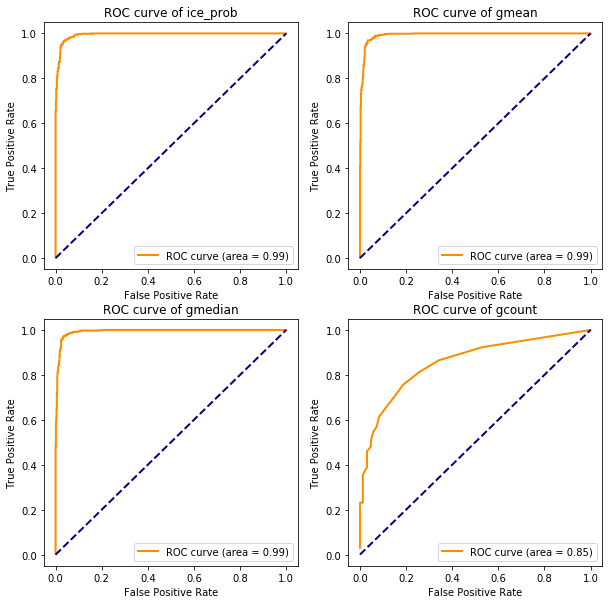

In [12]:
def plot_roc(y_true,y_pred,label):
    fpr, tpr, thresholds = roc_curve(y_true.astype('int'), y_pred,pos_label = 1,drop_intermediate = False)
    lw = 2
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',lw=lw,label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of '+label)
    plt.legend(loc='lower right')

labels=['ice_prob', 'gmean', 'gmedian', 'gcount']

fig = plt.figure(figsize = (10,10))
y_true = train['is_iceberg']
n_ax = 1
for label in labels:
    fig.add_subplot(220+n_ax)
    y_pred = train[label]
    plot_roc(y_true,y_pred,label)
    n_ax = n_ax + 1

plt.show()

### Use the labels of the training set to improve the precision of prediction
We already know the labels of the training set. We can use the label to improve the group prediction.

In [13]:
# we only need to tweak the values of the group that contains more than one member
data = pd.concat([train,test],axis = 0,ignore_index = True)
ls = data.groupby('inc_angle').count()['ice_prob']>1
# the angle_lst is to store the groups that have more than one member
angle_lst = ls[ls].index
print(angle_lst)

Float64Index([30.1586, 30.4373, 30.4878, 30.6681, 30.6966, 31.0434, 31.0446,
              31.0477, 31.3119, 31.3404,
              ...
              45.3846, 45.3867, 45.4055, 45.7359, 45.7622, 45.7649, 45.8848,
              45.8866, 45.9276, 45.9369],
             dtype='float64', name='inc_angle', length=719)


In [14]:
for l in angle_lst:
    temp = data[data['inc_angle']==l]
    res = []
    for m in range(temp.shape[0]):    
        a = temp.loc[temp.index[m],'ice_prob']
        temp2 = temp.drop(index = temp.index[m])
        for m in range(len(temp2)):
            if np.isnan(temp2.iloc[m,3]):
                a = a + temp2.iloc[m,0]
            else:
                a = a + temp2.iloc[m,3]
        a = a/len(temp)
        res.append(a)
    res = np.array(res)
    data.loc[data['inc_angle']==l,'gmean'] = res

In [15]:
for l in angle_lst:
    temp = data[data['inc_angle']==l]
    res = []
    for m in range(temp.shape[0]):    
        a = []
        a.append(temp.loc[temp.index[m],'ice_prob'])
        temp2 = temp.drop(index = temp.index[m])
        for m in range(len(temp2)):
            if np.isnan(temp2.iloc[m,3]):
                a.append(temp2.iloc[m,0])
            else:
                a.append(temp2.iloc[m,3])
        a = np.array(a)
        res.append(np.median(a))
    res = np.array(res)
    data.loc[data['inc_angle']==l,'gmedian'] = res

In [16]:
t0 = time()
score = []
for k in range(1,100):
    a = []
    for n in range(len(data)):
        temp = data.drop(index = n)
        if n<1471:
            y1 = temp.iloc[:1470,3]
            y2 = temp.iloc[1470:,0]
            y = np.concatenate((y1,y2))
            X = np.expand_dims(temp.iloc[:,2],axis = 1)
        reg = KNeighborsRegressor(n_neighbors=k, weights='distance', algorithm='brute')
        reg.fit(X,y)
        a.append(reg.predict(np.array([[data.loc[n,'inc_angle']]]))[0])
    a = np.array(a)
    a[a==0]=0.001
    a[a==1]=0.999
    score.append(log_loss(train.iloc[:,3],a[:len(train)]))
print(time() - t0)

1789.5095324516296


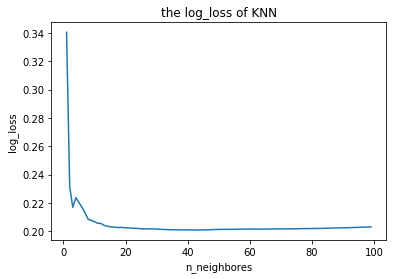

In [19]:
plt.plot(np.arange(1,100),np.array(score))
plt.title('the log_loss of KNN')
plt.xlabel('n_neighbores')
plt.ylabel('log_loss')
plt.show()

In [20]:
range(1,100)[np.argmin(np.array(score))]

43

In [21]:
t0 = time()
for n in range(len(data)):
    temp = data.drop(index = n)
    if n<1471:
        y1 = temp.iloc[:1470,3]
        y2 = temp.iloc[1470:,0]
        y = np.concatenate((y1,y2))
        X = np.expand_dims(temp.iloc[:,2],axis = 1)
    reg = KNeighborsRegressor(n_neighbors=43, weights='distance', algorithm='brute')
    reg.fit(X,y)
    data.loc[n,'KNN_prob'] = reg.predict(np.array([[data.loc[n,'inc_angle']]]))
print(time() - t0)

25.172959566116333


In [22]:
train = data.dropna()
train.head()

,ice_prob,id,inc_angle,is_iceberg,gmean,gmedian,gcount,KNN_prob
0,0.018964,dfd5f913,43.9239,0.0,0.012397,0.010356,3,0.009114
1,0.000006,e25388fd,38.1562,0.0,0.000006,0.000006,1,0.015138
2,0.792910,58b2aaa0,45.2859,1.0,0.765422,0.802449,34,0.764589
3,0.003594,4cfc3a18,43.8306,0.0,0.003594,0.003594,1,0.571834
4,0.002250,271f93f4,35.6256,0.0,0.009664,0.002250,3,0.013371


In [23]:
test = data[data['is_iceberg'].isnull()]
test.head()

,ice_prob,id,inc_angle,is_iceberg,gmean,gmedian,gcount,KNN_prob
1471,0.031928,5941774d,34.966400,NaN,0.007360,0.000011,13,0.007360
1472,0.485113,4023181e,32.615072,NaN,0.485113,0.485113,1,0.485113
1473,0.002311,b20200e4,37.505433,NaN,0.002311,0.002311,1,0.002311
1474,0.999246,e7f018bb,34.473900,NaN,0.998011,0.998276,5,0.998011
1475,0.032981,4371c8c3,43.918874,NaN,0.032981,0.032981,1,0.032981


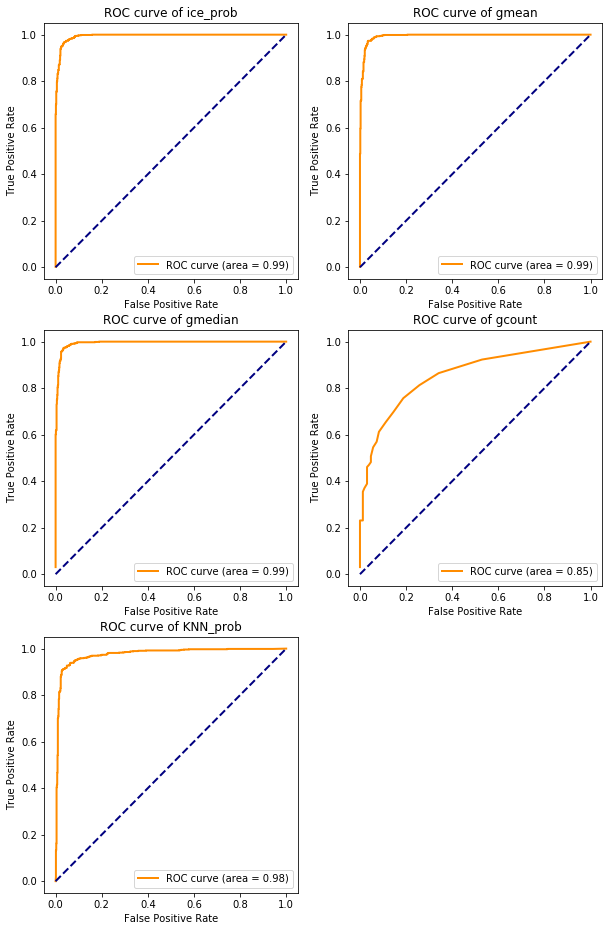

In [24]:
labels=['ice_prob', 'gmean', 'gmedian', 'gcount','KNN_prob']

fig = plt.figure(figsize = (10,16))
y_true = train['is_iceberg']
n_ax = 1
for label in labels:
    fig.add_subplot(320+n_ax)
    y_pred = train[label]
    plot_roc(y_true,y_pred,label)
    n_ax = n_ax + 1

plt.show()

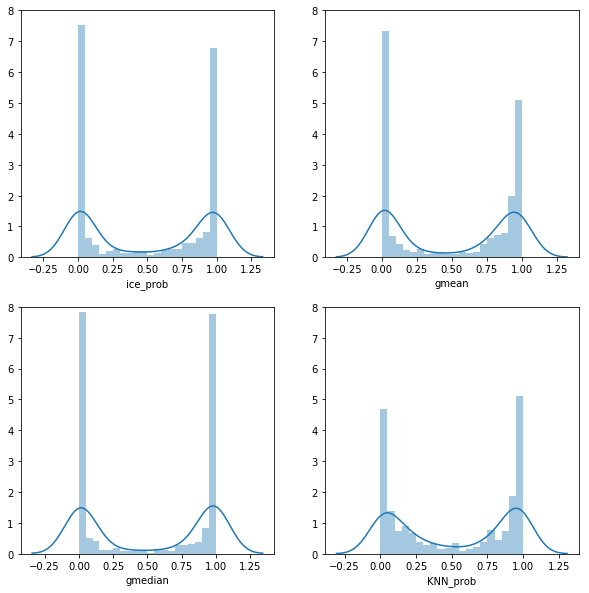

In [25]:
def plot_dist(prob):
    sns.distplot(prob,bins = 20)
    
labels=['ice_prob', 'gmean', 'gmedian','KNN_prob']
fig = plt.figure(figsize = (10,10))
n_ax = 1

for label in labels:
    fig.add_subplot(220+n_ax)
    prob = train[label]
    plot_dist(prob)
    plt.ylim([0,8])
    n_ax = n_ax + 1

plt.show()

In [26]:
a = train_angle_prob['id']
b = train['id']
b.index = a.index
print(np.sum(a == b))
a = test_angle_prob['id']
b = test['id']
b.index = a.index
print(np.sum(a == b))

1471
8424


In [27]:
data.loc[data['KNN_prob']==0,'KNN_prob']=0.001
data.loc[data['KNN_prob']==1,'KNN_prob']=0.999

data.dropna().to_csv('new_features/new_features_add_precision_train_k43.csv',index = False)
data[data['is_iceberg'].isnull()].to_csv('new_features/new_features_add_precision_test_k43.csv',index = False)